![Machine Learning for Scientists in a hurry](https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/Title_ML.png?raw=1)

# Boilerplate

In [1]:
!if [ ! -f helpers.py ]; then wget "https://raw.githubusercontent.com/romerogroup/Notebooks_4SIAH/main/Machine_Learning/helpers.py"; fi

In [2]:
# import some custom helper code
import helpers
from helpers import set_css_in_cell_output
get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

In [3]:
!pip install watermark wget

In [97]:
%%html
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 60%; padding: 5px">
  <h1 id="subtitle">Chapter 3. Classification</h1>
  <h2 id="subtitle">Guillermo Avendaño Franco<br>Aldo Humberto Romero</h2>
  <br>
  <img src="fig/1-line logotype124-295.png" alt="Scientific Computing with Python" style="width:50%" align="left">
  </div>
  <div style="border: none; float: left; width: 30%; padding: 5px">
  <img src="fig/SCPython.png" alt="Scientific Computing with Python" style="width:100%">
  </div>
</div>

<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 60%; padding: 5px">
  <h1 id="subtitle">Chapter 3. Classification</h1>
  <h2 id="subtitle">Guillermo Avendaño Franco<br>Aldo Humberto Romero</h2>
  <br>
  <img src="https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/1-line%20logotype124-295.png?raw=1" alt="Scientific Computing with Python" style="width:50%" align="left">
  </div>
  <div style="border: none; float: left; width: 30%; padding: 5px">
  <img src="https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/SCPython.png?raw=1" alt="Scientific Computing with Python" style="width:100%">
  </div>
</div>

## Setup

In [4]:
%load_ext watermark

In [5]:
%watermark

Last updated: 2023-10-23T02:19:20.033601+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.120+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [6]:
import os
import time
start = time.time()
chapter_number = 3
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import sklearn

In [8]:
%watermark -iv

sklearn   : 1.2.2
numpy     : 1.23.5
matplotlib: 3.7.1



# Where we are on the map?

<img src="https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/ml_map.png?raw=1" width="800" title="Precision vs Recall" alt="Precision vs Recall"></a>

# Classification

Classification and Regression are the foundations of many of the algorithms for Machine Learning, particularly supervised learning. In this case, the problem is to identify to which class or category new data belongs once we have trained the model with a set of data for which we know the output labels.

In machine learning and statistics, classification is the problem of identifying to which of a set of categories (sub-populations) a new observation belongs, based on a training set of data containing observations (or instances) whose category membership is known.

The following exercise provides a nice introduction to many of the relevant concepts in classification, some of them still valid when moving into the prediction of continuum values in regression problems.

# MNIST database

The MNIST database of handwritten digits, available from the link below, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal effort on preprocessing and formatting

Many methods have been tested with this training set and test set. For more information about the original datasets from NIST see [Yann LeCun Website](http://yann.lecun.com/exdb/mnist/)

In [9]:
# With internet access the dataset can be downloaded from OpenML.org
#from sklearn.datasets import fetch_openml
#mnist = fetch_openml('mnist_784', version=1, data_home="./openml/openml.org/", cache=True, n_retries=1)
#mnist.keys()

In [10]:
import os
import gzip
from scipy.io import arff
import pandas as pd
import requests

In [11]:
if not os.path.exists('data'):
  os.mkdir('data')

In [12]:
!if [ ! -f data/mnist_784.arff ]; then wget "https://www.openml.org/data/download/52667/mnist_784.arff" -O ./data/mnist_784.arff; fi

In [13]:
filename = "./data/mnist_784.arff.gz"
url = "https://www.openml.org/data/download/52667/mnist_784.arff"
if os.path.isfile(filename):
    arff_file = gzip.open(filename,'rt')
else:
    arff_file = "./data/mnist_784.arff"
data, meta = arff.loadarff(arff_file)

In [14]:
df=pd.DataFrame(data)

In [15]:
mnist = {}
mnist['data'] = df.drop('class', axis=1).astype('uint8')
mnist['target'] = df['class'].astype('uint8')

In [16]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [17]:
y.shape

(70000,)

In [18]:
type(X)

pandas.core.frame.DataFrame

In [19]:
type(y)

pandas.core.series.Series

In [20]:
X=X.to_numpy()
y=y.to_numpy()

Each image is a vector with 784 components corresponding to a matrix 28 x 28

In [21]:
28 * 28

784

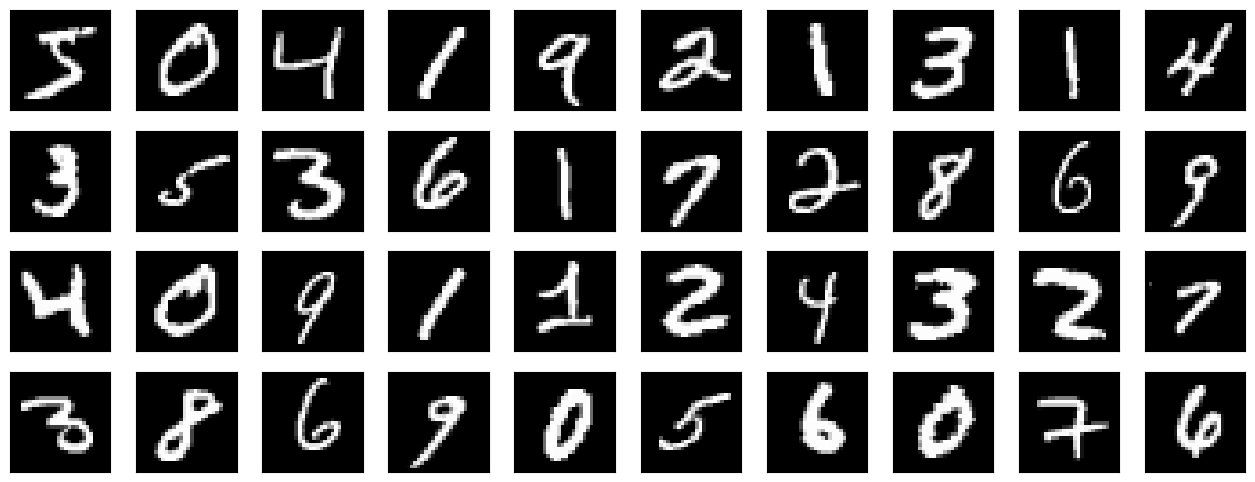

In [22]:
# Number of Rows
rgrid=4
# Number of Columns
cgrid=10
fig, axes = plt.subplots(rgrid,cgrid, figsize=(16,6))
for i in range(rgrid):
    for j in range(cgrid):
        #print(i,j,cgrid*i+j)
        axes[i,j].imshow(X[cgrid*i+j].reshape(28,28),interpolation='none',cmap='gray')
        axes[i,j].xaxis.set_ticks_position('none')
        axes[i,j].yaxis.set_ticks_position('none')
        axes[i,j].set_yticklabels([])
        axes[i,j].set_xticklabels([])

In [23]:
y[:12].reshape(2,6)

array([[5, 0, 4, 1, 9, 2],
       [1, 3, 1, 4, 3, 5]], dtype=uint8)

In [24]:
y = y.astype(np.uint8)

In [25]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off");

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off");

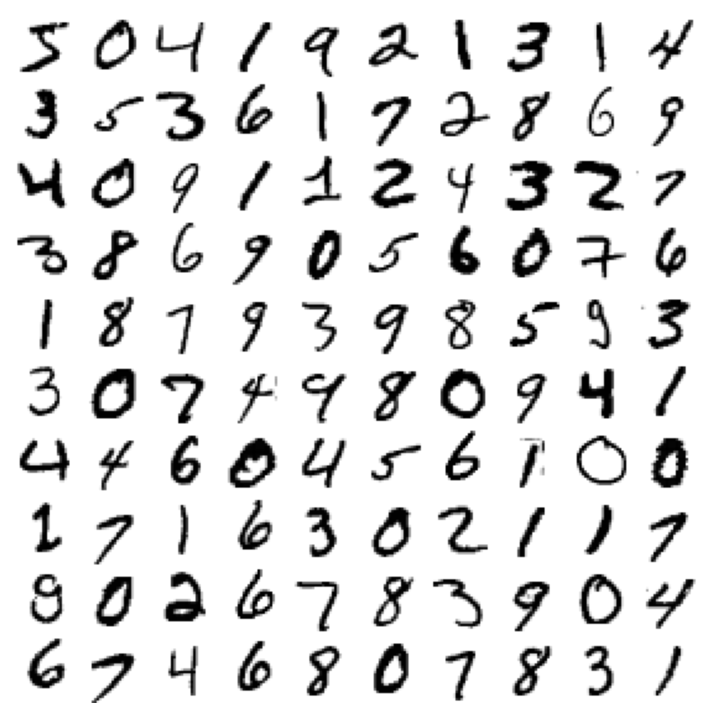

In [26]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)

In [27]:
y[0]

5

In [28]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary classifier

Later we will attack the problem of classifying all the ten digits. For now let's focus on a more modest classification problem, where we will try to identify if a given number is 5 or not.

In [29]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Note**: some hyperparameters will have a different default value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

There are several classifiers implemented in Scikit-Learn, the Stochastic gradient descent (SGD) `SGDClassifier` is a simple yet very efficient approach to fit linear models. While SGD is in reality an iterative method used to optimize the solution in an objective function with smooth properties but doing that stochastically, the classifier with SGD uses this method but now with a regularized linear model.
It is particularly useful when the number of samples (and the number of features) is very large as it does not need to have the whole database in RAM. This process is then obtained by following the negative gradient of the objective after seeing only a single or a few training data.

A nice discussion on the Stochastic gradient descent can be found at [SGD site](https://www.geeksforgeeks.org/ml-stochastic-gradient-descent-sgd/), where we have taken the figures below. Left-hand side represents a batch gradient descent where a batch of random data is used and right-hand side is the stochastic gradient descent where a single random sample has been used for each step.

<table><tr><td><img src='https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/gdp.png?raw=1' alt="Batch Gradient Descent" style="width:60%"></td><td><img src='https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/gdp-1.jpg?raw=1' alt="Stochastic Gradient Descent" style="width:60%"></td></tr></table>
</a>

Right now the point is to get a black box that does classification for us.

In [30]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [31]:
sgd_clf.predict(X_train[:12])

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True])

In [32]:
y_train[:12]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

We can see that indeed the classifier seems to work fine. How to quantify that?

## Accuracy

The first measure will be accuracy, the total number of right answers versus the total number of misses

\begin{equation}
accuracy = \frac{\text{Total number of right answers}}{\text{Total number of cases}}
\end{equation}

We can do that for several subsets of the train set, in what is called **cross validation**

In [33]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

However, we can create a new classifier that always answers negatively no matter what vector is presented.

In [34]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [35]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

We got 90% accuracy, which is consistent with a set of many cases where each digit is represented with the same frequency as any other.

## Confusion matrix

A better way of looking at the performance of a classifier is via the confusion matrix. A matrix that for each instance can be divided into 4 sets

 * **True positives** Images that are 5s and were identified as 5s
 * **True negatives** Images that are NOT 5s and were identified as NOT 5s
 * **False positives** Images that are NOT 5s but were identified as 5s
 * **False negatives** Images that are 5s but were identified as NOT 5s

In [36]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred = sgd_clf.predict(X_train)

In [37]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52316,  2263],
       [  601,  4820]])

A perfect confusion matrix will look like this:

In [38]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision, Recall and F1

<img src="https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/Precision_Recall.png?raw=1" width="700" height="200" title="Precision vs Recall" alt="Precision vs Recall"></a>

Instead of using the **accuracy** a better metric could use the precision and recall as defined by:

\begin{equation}
precision = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
\end{equation}

---

\begin{equation}
recall = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
\end{equation}

Finally there is one metric that measures the balance between precision and recall

\begin{equation}
F_1 = \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
\end{equation}


In [39]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.6805026118876183

In [40]:
# TP = 4820
# FP = 2263
4820 / (4820 + 2263)

0.6805026118876183

In [41]:
recall_score(y_train_5, y_train_pred)

0.8891348459693783

In [42]:
# TP = 4820
# FN = 601
4820 / (4820 + 601)

0.8891348459693783

In [43]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7709532949456175

In [44]:
4820 / (4820 + (601 + 2263) / 2)

0.7709532949456174

### Decision Function

Scikit-learn provides a function to show the value that the SGD assigns to each set of inputs. See for example the first 12

In [45]:
y_scores = sgd_clf.decision_function(X_train[:12])
y_scores

array([  2164.22030239,  -5897.37359354, -13489.14805779,  -4623.84515943,
        -6873.05248453,  -3908.27576291,  -4851.9422397 ,  -4988.52407755,
        -2226.78132866,  -4081.33692831,  -5711.47789687,   4742.52813158])

Notice that images identified with 5 received positive scores and other numbers received negative scores.

In [46]:
y_train[:12]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

## Changing the threshold

one interesting observation is to notice that if by any means we could change the threshold of acceptance for considering an image a 5 we increase the precision (by reducing FP) but at the expenses of also reducing the recall (by also increasing the FN). In summary precision and recall are two conflicting quantities.

In [47]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [48]:
y_some_digit_pred

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True])

In [49]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [50]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [51]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

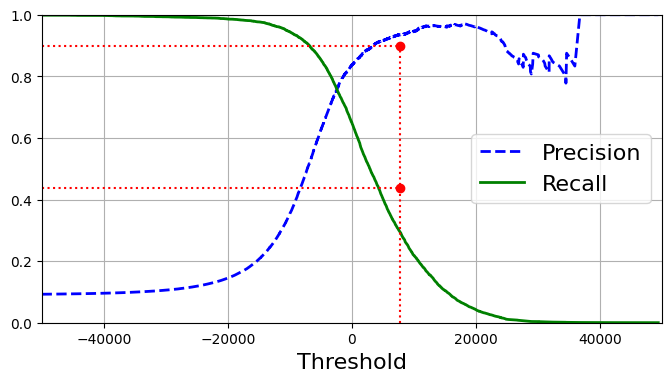

In [52]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plt.figure(figsize=(8, 4))                      # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([7813, 7813], [0., 0.9], "r:")         # Not shown
plt.plot([-50000, 7813], [0.9, 0.9], "r:")      # Not shown
plt.plot([-50000, 7813], [0.4368, 0.4368], "r:")# Not shown
plt.plot([7813], [0.9], "ro")                   # Not shown
plt.plot([7813], [0.4368], "ro")                # Not shown

In [53]:
(y_train_pred == (y_scores > 0)).all()

False

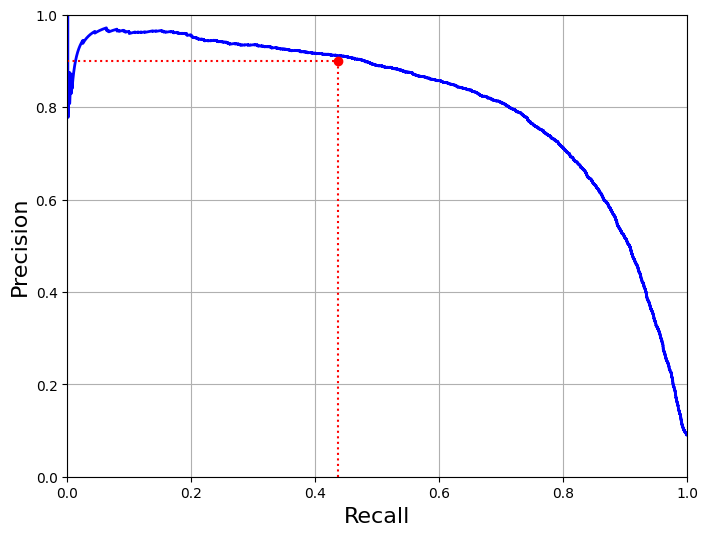

In [54]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro");

In [55]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [56]:
threshold_90_precision

3370.0194991439557

In [57]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [58]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [59]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC curves

The Receiver Operating Characteristic (ROC) is a plot of recall (also known as *True Positive Rate*) against False Positive Rate (FPR) that is one minus the True Negative Rate (TNR) (Negative instances correctly identified as negative)

 * FPR = 1 - TNR = 1 - specificity
 * TPR = Recall = sensitivity

In [60]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

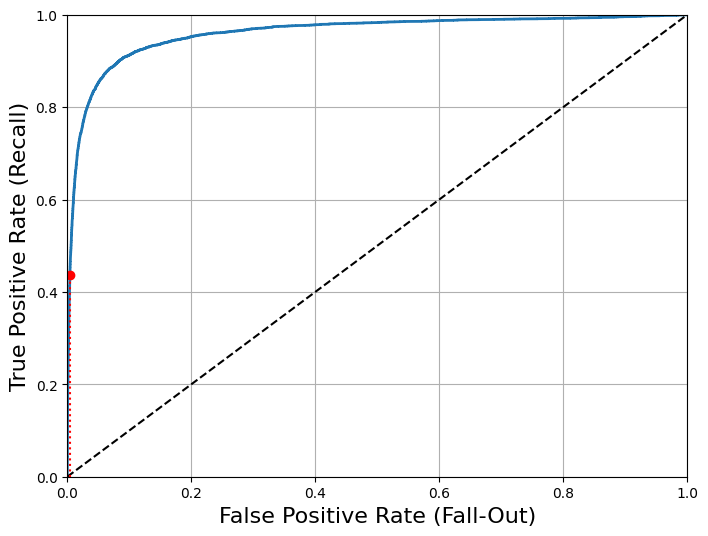

In [61]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown

In [62]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

In [63]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [64]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

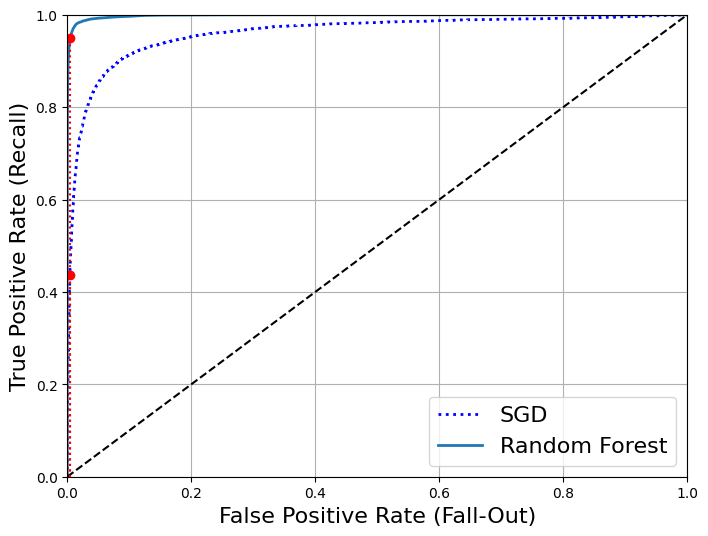

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

In [66]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [67]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [68]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass classification

The case until now was a binary classifier, but the MNIST is a multiclass classification problem.
Therefore, the goal is to construct a function which, given a new data point, will correctly predict the class to which the new data belongs.

There are several Multiclass classifiers in Scikit-learn. Some are binary, others are directly multiclass as KNN, decision trees, neural networks, logistic regression, Naive Bayes,

The simplest would be the OVA method (one vs all), which basically treat the multiclass classification as a set of binary classification. Here we train each binary classifier independently to solve the binary task. A simple example is seen in the left-hand side of figure below. Each figure corresponds to a single class.   

Note: depending on the binary classifier is set up, there is a chance that you get contradictory results, especially if you have imbalanced data. If that happens, it is a good idea to use a discriminant function or using the loss function. A nice intro about this idea can be found in [Loss function description](https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23).

The other possibility is to use one-to-one classification, which basically considers all possible pairs, as depicted on the center in the figure below. Here the benefit is that the training set is smaller, though there is a larger number of classifiers. Though it seems that you have to do more work, it is not the case, as the classification for each pair is much smaller, which can be easily parallelized.

Another method is the so-called **error correcting output codes**, which is one of the most used methods nowadays, and it is an ensemble method. First of all, a code matrix is created, which is a binary representation for each one of the classes, each code is different for each class and the binary representation is also called a codeword. The next step is to use several binary classification algorithms on the same data, where each outcome is a binary value. These binary classification algorithms are called learners. Therefore, each new instance is evaluated by the learners and they are compared with the already assigned binary classification for the existing class (usually the so called Hamming distance is used for this process). If the distance is zero, the class exists and it can be assigned to that particular class. Usually, we use more binary classifications than those required to write the data in a binary representation, similar to the methods used in error correction in computer systems. The larger the number of learners, the performance of the classifier becomes better. A simple form of a binary representation is shown on the right-hand side in the figure below.

<table><tr><td><img src='https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/MultiClassClassification_1.jpeg?raw=1' alt="OtoA" style="width:90%"></td><td><img src='https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/MultiClassClassification_2.jpeg?raw=1' alt="OtoO" style="width:90%"></td><td><img src='https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/MultiClassClassification_3.jpeg?raw=1' alt="ECOC" style="width:90%"></td></tr></table>


Here we need to be aware about the quality type of data we will be using. For example, if we have imbalanced data, this typically refers to a problem with classification problems where the classes are not represented equally. Therefore before we use any algorithm, we should become familiar with the type of data we have at hand.

In the following example, we will use a supporting vector machine as the classifier for our 10-dimensional data. As discussed before, SVC method is a classifier where a hyperplane that separates the data in classes is formally defined.


is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane that categorizes new examples. In two-dimensional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.
Gamma is one of the regularization parameters and allows some nonlinear classification line.
With low gamma, points far away from plausible separation plane are considered in the calculation for the separation plane. Whereas high gamma means the points close to the plausible plane are considered in the calculation.


Here we are using the default kernel, as described in [Scikit SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC). A simple understanding of what is kernel can be seen in **linear kernel**, where the equation used for prediction from a new input $x_i$set can be obtained from the dot product between the input and each support vector $a_i$ as calculated by $f(x) = B(0) + \sum a_i x_i$, where the. Some other kernels are polynomial, exponential, etc.




In [69]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict(X_train[:12])

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [70]:
y_train[:12]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [71]:
scores_for_5 = svm_clf.decision_function(X_train[:1])
scores_for_5

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [72]:
np.argmax(scores_for_5)

5

In [73]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [74]:
svm_clf.classes_[5]

5

In [75]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict(X_train[:12])

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [76]:
len(ovr_clf.estimators_)

10

In [77]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [78]:
sgd_clf.predict(X_train[:12])

array([3, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [79]:
sgd_clf.decision_function(X_train[:1])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [80]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [81]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled[:1000], y_train[:1000], cv=3, scoring="accuracy")

array([0.84431138, 0.81381381, 0.77177177])

In [82]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled[:1000],
                                 y_train[:1000], cv=3)
conf_mx = confusion_matrix(y_train[:1000], y_train_pred[:1000])
conf_mx

array([[ 88,   0,   0,   0,   0,   7,   2,   0,   0,   0],
       [  1, 100,   3,   0,   0,   4,   0,   1,   5,   2],
       [  2,   3,  73,   3,   2,   3,   3,   4,   5,   1],
       [  0,   1,   7,  74,   1,   5,   0,   2,   0,   3],
       [  1,   0,   1,   2,  85,   4,   2,   1,   2,   7],
       [  0,   2,   2,   9,   4,  65,   1,   1,   6,   2],
       [  2,   2,   3,   0,   2,   4,  81,   0,   0,   0],
       [  0,   0,   2,   1,   4,   0,   0, 104,   0,   6],
       [  0,   4,   2,   0,   0,   6,   2,   1,  70,   2],
       [  5,   0,   0,   1,   5,   1,   0,  17,   1,  70]])

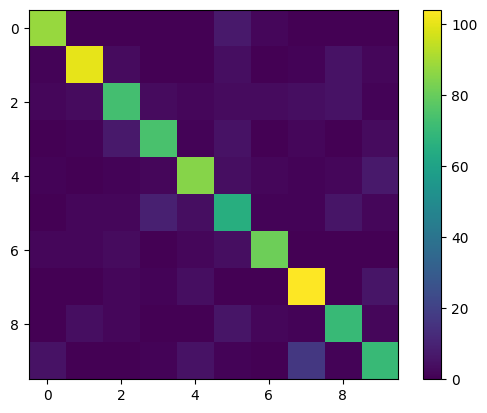

In [83]:
plt.imshow(conf_mx)
plt.colorbar();

In [84]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

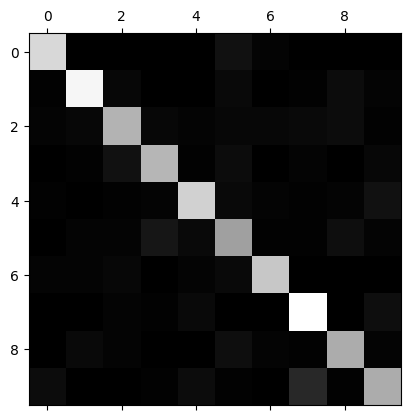

In [85]:
plt.matshow(conf_mx, cmap=plt.cm.gray);

In [86]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

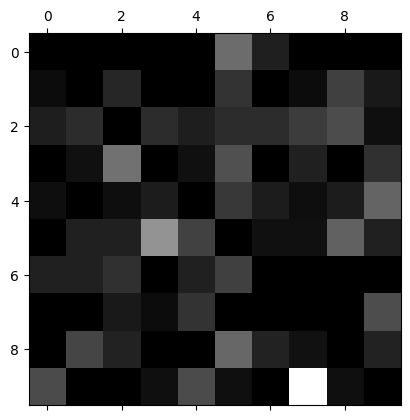

In [87]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray);

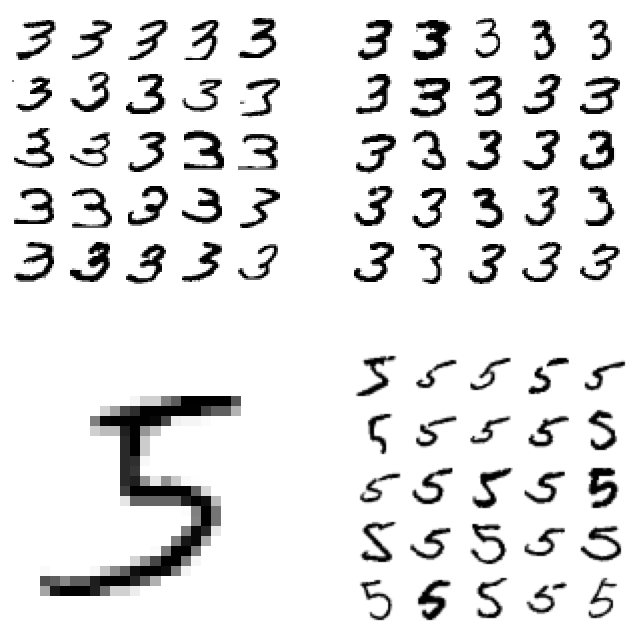

In [88]:
y_train_pred = sgd_clf.predict(X_train_scaled)

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# Multilabel classification

In [89]:
# Two classifications, larger than 7 or if it is even or odd
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [90]:
knn_clf.predict(X_train[:4])

array([[False,  True],
       [False, False],
       [False, False],
       [False,  True]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [91]:
y_train_knn_pred = knn_clf.predict(X_train[:100])
f1_score(y_multilabel[:100], y_train_knn_pred, average="macro")

0.9862775751259336

# Multioutput classification

In [92]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

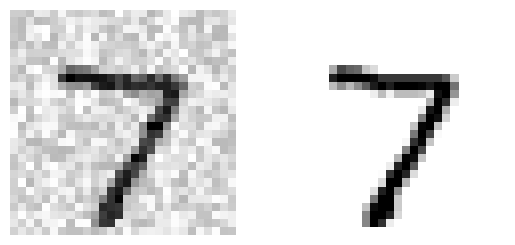

In [93]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

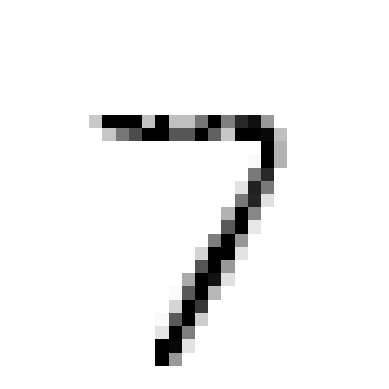

In [94]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

---

# Acknowledgments

This notebook is based on a variety of sources, usually other notebooks, the material was adapted to the topics covered during lessons. In some cases, the original notebooks were created for Python 2.x or older versions of Scikit-learn or Tensorflow and they have to be adapted to at least Python 3.7.

We acknowledge the support of the National Science Foundation and the US Department of Energy under projects: DMREF-NSF 1434897, NSF OAC-1740111 and DOE DE-SC0016176 is recognized.

<div style="clear: both; display: table;">
<div style="border: none; float: left; width: 40%; padding: 10px">
<img src="https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/NSF.jpg?raw=1" alt="National Science Foundation" style="width:50%" align="left" height="100" width="100">
    </div>
    <div style="border: none; float: right; width: 40%; padding: 10px">
<img src="https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/DOE.jpg?raw=1" alt="National Science Foundation" style="width:50%" align="right" height="100" width="100">
</div>

---

# References

The snippets above are meant only to give a brief introduction to some of the most popular techniques in machine learning so you can decide whether this kind of analysis might be useful in your research. If it seems like machine learning will be important in your work, you may want to check out some of the resources listed below (arranged roughly from least to most technical):

This list is by no means an exhaustive list of books and resources. I am listing the books from which I took inspiration. Also, I am listing materials where I found better ways to present topics. Often I am amazed by how people can create approachable materials for seemingly dry subjects.

The order of the books goes from divulgation and practical to the more rigorous and mathematical. Slides, blogs, and videos are those I have found over the internet or suggested by others.

### Selection of Books on Machine Learning

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Hands-On Machine Learning  with Scikit-Learn and TensorFlow"
       src="https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/books/Hands-On%20Machine%20Learning%20%20with%20Scikit-Learn%20and%20TensorFlow.jpg?raw=1"
       height="160" width="120"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Hands-On Machine Learning  with Scikit-Learn and TensorFlow (First Edition [There is a second edition])<br>
      Auréleien Géron<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Python Machine Learning - Raschka"
       src="https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/books/Python%20Machine%20Learning%20-%20Raschka.jpg?raw=1"
       height="160" width="120"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Machine Learning, a Probabilistic Perspective<br>
      Sebastian Raschka and Vahid Mirjalili<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Foundations of Machine Learning - Mohri"
       src="https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/books/Foundations%20of%20Machine%20Learning%20-%20Mohri.jpg?raw=1"
       height="160" width="120"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Foundations of Machine Learning (Second Edition)<br>
      Mehryar Mohri, Afshin Rostamizadeh and Ameet Talwalkar<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Machine Learning - Alpaydin"
       src="https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/books/Introduction%20to%20Machine%20Learning%20-%20Alpaydin.jpg?raw=1"
       height="160" width="120"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Machine Learning (Fourth Edition)<br>
      Ethem Alpaydin<br>
      2020<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Machine Learning, a Probabilistic Perspective - Murphy"
       src="https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/books/Machine%20Learning,%20a%20Probabilistic%20Perspective%20-%20Murphy.jpg?raw=1"
       height="160" width="120"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Machine Learning, a Probabilistic Perspective<br>
      Kevin P. Murphy<br>
      2012<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Elements of Statistical Learning - Hastie"
       src="https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/books/Elements%20of%20Statistical%20Learning%20-%20Hastie.jpg?raw=1"
       height="160" width="120"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      <a href="https://hastie.su.domains/Papers/ESLII.pdf">Elements of Statistical Learning</a><br>
      Trevor Hastie, Robert Tibshirani, and Jerome Friedman<br>
      2008<br>
  </div>
</div>


### Jupyter Notebooks

 * [Yale Digital Humanities Lab](https://github.com/YaleDHLab/lab-workshops)

 * Aurelien Geron Hands-on Machine Learning with Scikit-learn
   [First Edition](https://github.com/ageron/handson-ml) and
   [Second Edition](https://github.com/ageron/handson-ml2)
   
 * [A progressive collection notebooks of the Machine Learning course by the University of Turin](https://github.com/rugantio/MachineLearningCourse)
   
 * [A curated set of jupyter notebooks about many topics](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)
   
### Videos

 * [Caltech's "Learning from Data" by Professor Yaser Abu-Mostafa](https://work.caltech.edu/telecourse.html)


 * [A Friendly Introduction to Machine Learning](https://www.youtube.com/watch?v=IpGxLWOIZy4)

In this 30-minute video, Luis Serrano (head of machine learning at Udacity) offers intuitive, user-friendly introductions to the mechanics that drive several machine learning models, including Naive Bayes, Decision Tree, Logistic Regression, Neural Network, and Support Vector Machine classifiers. This video is a great place to start for those looking for quick intuitions about the ways these algorithms work.

 * [Hands-On Machine Learning with Scikit-Learn and TensorFlow (OREILLY)](http://shop.oreilly.com/product/0636920052289.do)

This OREILLY book offers a great high-level introduction to machine learning with Python. Aurélien Géron guides readers through ways one can use scikit-learn and other popular libraries to build machine learning models in Python. This is a great choice for those who just want to get work done, without necessarily unlocking the insights that would allow one to build models from scratch.

 * [Machine Learning Cheatsheets](https://becominghuman.ai/cheat-sheets-for-ai-neural-networks-machine-learning-deep-learning-big-data-678c51b4b463)

This collection of "cheat sheets" gives concise overviews of the API's and models behind many of the most prominent packages and concepts in machine learning and its allied fields, including different neural network architectures, numerical optimization techniques, algorithms appropriate for different tasks, scikit-learn, pandas, scikit-learn, scipy, ggpot2, dplyr and tidyr, big O notation, and several other topics. Recently identified as the "most popular" article on machine learning in Medium.

 * [Mining of Massive Datasets](http://www.mmds.org/)

This Stanford University course and digital publication offer introductions to a wide array of subtopics in machine learning. The authors focus on helping readers gain an intuitive understanding of how machine learning models work. One of the most lucid and concise treatments of machine learning available on the web.

 * [Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/)

This Stanford University course offers a spectacular introduction to Convolutional Neural Networks, the cornerstone of modern machine learning in the domain of computer vision. If your work involves images or video materials, and you'd like to apply machine learning techniques to your data, this course will help you get up and running with state-of-the-art techniques in convnets.

 * [Machine Learning (Andrew Ng, Coursera)](https://www.coursera.org/learn/machine-learning)

Andrew Ng's Coursera course on machine learning will help you master many of the fundamentals involved in modern machine learning. Professor Ng will guide you through a great deal of the math involved in contemporary machine learning, starting with simple linear classifiers and building up into complex neural network architectures. This class is ideal for those who like to understand the math behind the models they use.

 ---

# Back of the Book

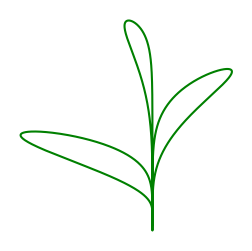

In [95]:
plt.figure(figsize=(3,3))
n = chapter_number
maxt=(2*(n-1)+3)*np.pi/2
t = np.linspace(np.pi/2, maxt, 1000)
tt= 1.0/(t+0.01)
x = (maxt-t)*np.cos(t)**3
y = t*np.sqrt(np.abs(np.cos(t))) + np.sin(0.3*t)*np.cos(2*t)
plt.plot(x, y, c="green")
plt.axis('off');

In [96]:
end = time.time()
print(f'Chapter {chapter_number} run in {int(end - start):d} seconds')

Chapter 3 run in 912 seconds
